## **STAT 301 Project individual assignment 2: Methods & Plan**
**Ellie Wakefield**

In [1]:
library(broom)
library(repr)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(modelr)
library(tidyverse)
library(dplyr)

install.packages("gridExtra")

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: ‘modelr’


The following objects are masked from ‘package:mltools’:

    mse, rmse


The following object is masked from ‘package:broom’:

    bootstrap


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ modelr::bootstrap() masks broom::bootstrap()
✖ dplyr::combine()    masks gridExtra::combine()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ modelr::mse()       masks mltools::mse()
✖ tidyr::pack()       masks Matrix::pack()
✖ tidyr::replace_na() masks mltools::replace_na()
✖ modelr::rmse()      masks mltools::rmse()
✖ lubridate::stamp(

## (0) Project Proposal
**0.1 Data Description**
<br> This data was collected through GitHub search API, and accessed through Kaggle. The dataset contains information on the top 215,000 Github repositories constrained to the repositories with over 167 stars. It includes the following 24 variables:
- Name (character): name of repository
- Description (character): summary of repository's purpose, focus
- URL (character): URL link to repository
- Created At (date, time): date and time when repository was first created on GitHub
- Updated At (date, time): date and time of repository's most recent udpate or modification
- URL (character): URL link to repository's homepage
- Size (double): size of repository, in bytes
- Stars (double): number of stars (likes) repository has received from other GitHub users
- Forks (double): number of times repository has been forked by other GitHub users
- Issues (double): number of open issues of repository
- Watchers (double): number of GitHub users watching/monitoring repository for changes
- Language (character): repository's primary programming language
- License (character): software licence information
- Topics (character): list of associated topics
- Has Issues (boolean): whether repository has issue tracker enabled
- Has Projects (boolean): whether GitHub Projects is used to manage/organize tasks
- Has Downloads (boolean): whether downloadable files/assets are offered to users
- Has Wiki (boolean): whether there is an associated wiki with additional information
- Has Pages (boolean): whether GitHub Pages is enabled
- Has Discussions (boolean): whether GitHub Discussions is enabled, allowing for discussion/collaboration
- Is Fork (boolean): whether repository is a fork of another repository
- Is Archived (boolean): whether repository is archived (read-only)
- Is Template (boolean): whether repository is set up as a template
- Default Branch (character): name of default branch

For our purposes, we are mostly interested in variables that may be associated with Stars such as the size of the repository in bytes (indicating the total storage space used by the repository's files and data) and the number of times the repository has been forked by other GitHub users. Another variable that could be relevant is whether the repository offers downloadable files or assets to users, due to the resulting increase in accessibility. Thus we will remove some irrelevant variables/columns from the dataset.

The dataset is very large, containing over 215,000 rows or observations (each corresponding to a repository), so I chose to take a simple random sample of size 1,000 to use for all further data analysis, visualization and modelling.


**0.2 Question**
<br> ***Can we use one quantitative and one categorical variable to accurately predict the number of stars a GitHub repository has?***

The data will help us to answer this question, as we can use various methods of model selection in order to fit a linear regression model to our data, with number of stars as our response variable. Our question is focused on prediction, but it will also allow us to infer which variables, if any, are associated with our response.

**0.3 Exploratory Data Analysis and Visualization**

In [2]:
set.seed(8035)
library(readr)
# Read in the dataset
repo <- read_csv("./repositories.csv")
# Remove unused columns, take stratified random sample grouped by Stars >= median and Stars < median
stars_med = median(repo$Stars)
repo_strat_sample <- repo %>%
    select(-Name, -Homepage, -Description, -Watchers, -URL, -'Created At', -'Updated At', -Language, -License, -Topics, -'Default Branch', -'Is Archived', -'Is Fork', 'Is Template', -'Has Issues', -'Has Downloads') %>%
    mutate(no_stars = ifelse(Stars >= stars_med, "high", "low")) %>%
    group_by(no_stars) %>%
    sample_n(size = 500, replace = FALSE) %>%
    ungroup() %>%
    select(-no_stars)
head(repo_strat_sample)
nrow(repo_strat_sample)

Rows: 215029 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): Name, Description, URL, Homepage, Language, License, Topics, Defau...
dbl  (5): Size, Stars, Forks, Issues, Watchers
lgl  (9): Has Issues, Has Projects, Has Downloads, Has Wiki, Has Pages, Has ...
dttm (2): Created At, Updated At

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Size,Stars,Forks,Issues,Has Projects,Has Wiki,Has Pages,Has Discussions,Is Template
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
28512,413,119,3,TRUE,TRUE,FALSE,FALSE,FALSE
3627,952,145,132,TRUE,TRUE,FALSE,FALSE,FALSE
9586,1175,167,29,TRUE,TRUE,FALSE,FALSE,FALSE
1248,848,122,40,TRUE,TRUE,FALSE,FALSE,FALSE
6480,1283,409,34,TRUE,TRUE,TRUE,FALSE,FALSE
3556,578,104,2,FALSE,FALSE,FALSE,FALSE,FALSE


[1] 1000

In [3]:
# Log-transform Size and Stars columns, and set 'Has Discussions' as factor
repo_sample_log <- repo_strat_sample %>%
    mutate(Size = log(Size + 1),
          Stars = log(Stars + 1),
           Forks = log(Forks + 1),
          `Has Discussions` = as.factor(`Has Discussions`))
head(repo_sample_log)

Size,Stars,Forks,Issues,Has Projects,Has Wiki,Has Pages,Has Discussions,Is Template
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<fct>,<lgl>
10.258115,6.025866,4.787492,3,TRUE,TRUE,FALSE,FALSE,FALSE
8.196437,6.859615,4.983607,132,TRUE,TRUE,FALSE,FALSE,FALSE
9.168163,7.069874,5.123964,29,TRUE,TRUE,FALSE,FALSE,FALSE
7.130099,6.744059,4.812184,40,TRUE,TRUE,FALSE,FALSE,FALSE
8.776630,7.157735,6.016157,34,TRUE,TRUE,TRUE,FALSE,FALSE
8.176673,6.361302,4.653960,2,FALSE,FALSE,FALSE,FALSE,FALSE


In [4]:
# Create plots
stars_vs_size <- repo_sample_log %>% 
    ggplot(aes(x = Size, y = Stars)) + 
    geom_point(shape = 21, size = 2, color = "magenta") + 
    labs(x = "Size of repository", 
         y = "No. stars") +
    theme_minimal() +
    ggtitle("Size and number of stars of repositories")
stars_vs_forks <- repo_sample_log %>% 
    ggplot(aes(x = Forks, y = Stars)) + 
    geom_point(shape = 21, size = 2, color = "magenta") + 
    labs(x = "No. forks", 
         y = "No. stars") +
    theme_minimal() +
    ggtitle("Size and number of stars of repositories")
stars_vs_discussions <- repo_sample_log %>%
    ggplot(aes(x = `Has Discussions`, y = Stars, fill = `Has Discussions`)) +
    geom_boxplot() +
    labs(x = "Has Discussions", y = "No. stars") +
    scale_fill_manual(values = c("TRUE" = "orange", "FALSE" = "lightpink")) +
    theme_minimal() +
    ggtitle("Distribution of stars by existence of discussions")
has_discussions_counts <- repo_sample_log %>%
    ggplot(aes(x = `Has Discussions`, fill = `Has Discussions`)) +
    geom_bar() +
    scale_fill_manual(values = c("TRUE" = "orange", "FALSE" = "lightpink")) + 
    theme_minimal() + 
    ggtitle("Counts of has discussions")

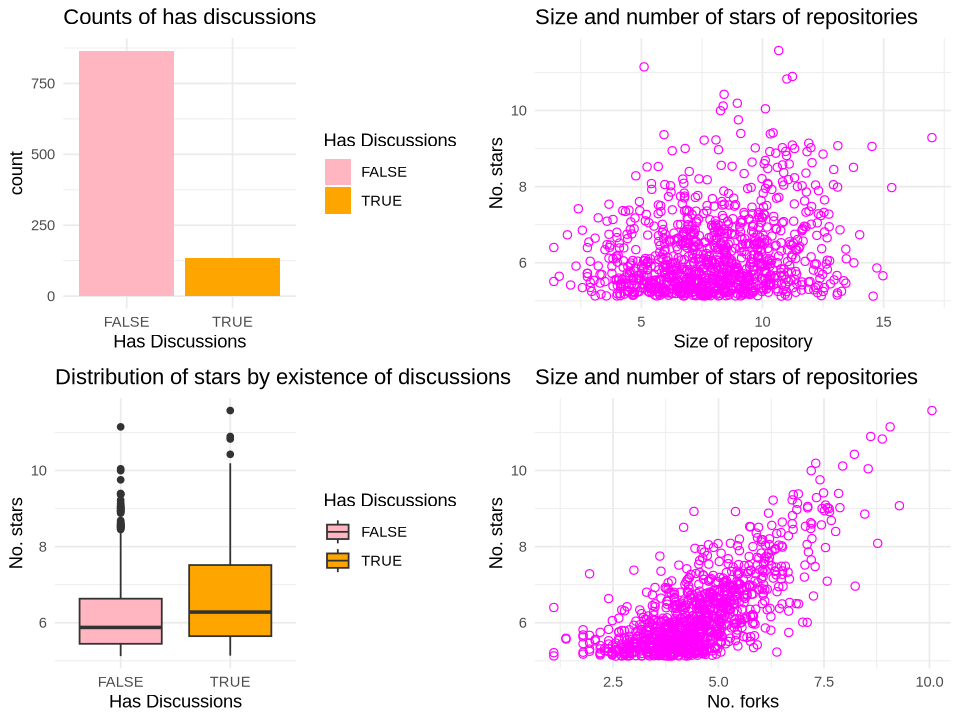

In [5]:
options(repr.plot.width = 8, repr.plot.height = 6) 
# Display plots in a grid arrangement
grid.arrange(has_discussions_counts, stars_vs_size, stars_vs_discussions, stars_vs_forks, ncol = 2)

I created three plots to visualize various aspects of the data that are helpful in my initial exploration of the dataset.

Note that prior to creating visualizations, I log-transformed the variables of Size and Stars in order to make the scale of the variables easier to work with (log(...+1) to account for zeroes in the data). I also reformatted the 'Has Discussions' to be a factor.

(i) I created a bar plot showing the counts for repositories which have downloads and those which do not. This is helpful in providing context for the following two plots which both involve the 'Has Discussions' variable. It is noticeable that there are significantly more repositories which do not have downloads compared with those that do, so we should keep this in mind as we perform subsequent visualization and proceed with data analysis.

(ii) I created a scatterplot to visualize the relationship between the size of a repository and the number of stars it has. Based on the distribution of points in the scatterplot there does not appear to be a linear relationship between stars and size.

(iii) Lastly, I created side-by-side boxplots to visualize the distribution of stars for repositories with downloads and those without. Keeping in mind, as seen in plot (i), the number of repositories with downloads is comparitively low compared to those with downloads, it appears that repositories that have downloads tend to have more stars than those who do not. This is implied by the line corresponding to the mean number of stars is higher for the boxplot corresponding to 'Has Discussions' = TRUE.

## (1) Methods and plan 

**1.1 Note: changes from proposal**
<br> Note that I made the following changes to initial data cleaning and visualisation since the initial proposal:
1. Removed columns 'Is Fork', 'Is Template', 'Has Issues', 'Has Downloads' and 'Is Archived' for the reason that these columns were either entirely or nearly (>90%) constant, i.e. almost all values same, meaning they would not be helpful to include as possible predictors in future analysis and model selection.
2. Log-transformed 'Forks' variable.
3. Added scatterplot comparing 'Stars' and 'Forks'.
4. Took a stratified random sample to use for future analysis, rather than simple random sample, where half of the observations have a "high" number of stars (>= median) and half have a "low" number. This ensures a more even distribution of Stars in our sample.
5. Made slight changes to the wording of my research question.

**1.2 Addressing key assumptions:**

*(a) No severe multicollinearity*
<br> To check for multicollinearity, I will create a correlation matrix to identify significant linear associations or dependencies between covariates.

*(b) Approximately linear relationship*
<br> We assume a roughly linear relationship between response and covariates. Preliminary analysis suggests a fairly linear relationship between `Stars` and `Forks`, supporting this assumption.

*(c) No ommitted key covariates*
<br> All variables excluded from the original dataset were intentionally removed in confidence that they are not relevant predictors for `Stars`.

*(d) Independence of observations*
<br> We assume each repository is distinct and independent from one another.

**1.3 Overview of model selection method**
<br> I chose forward selection as my method of selecting a reduced model. This approach begins with the intercept-only model and adds covariates one at a time, selecting the best model of each size (i.e. number of covariates) based on the lowest residual sum of squares (RSS). Based on these results I will select the model with the lowest $C_p$ value, which identifies the best predictive model regarding goodness of fit. To evaluate its performance, I will compare this reduced model against a full model (regressing `Stars` on all 7 covariates) using Root Mean Squared Error (RMSE) to analyze the predictive power of the selected covariates and address our research question.

Forward selection is appropriate for this analysis because it is computationally efficient, simple to implement, and adheres to the principle of parsimony, balancing predictive power and interpretability. This aligns with my goal of identifying the subset of covariates that will be most helpful in predicting `Stars` while maintaining interpretability.

However, forward selection has some limitations. It may not find the globally optimal model, especially if certain variables improve predictive power only when included together. Additionally, it focuses on minimizing in-sample error, which may not ensure the model generalizes well to new data. Comparing the RMSE of the reduced and full models will help address this concern.

By applying forward selection and evaluating the resulting model, I aim to identify a reduced model with strong predictive power and interpretability, effectively addressing my research question.

## (2) Computational code and output
**2.1 Implementation of proposed model**

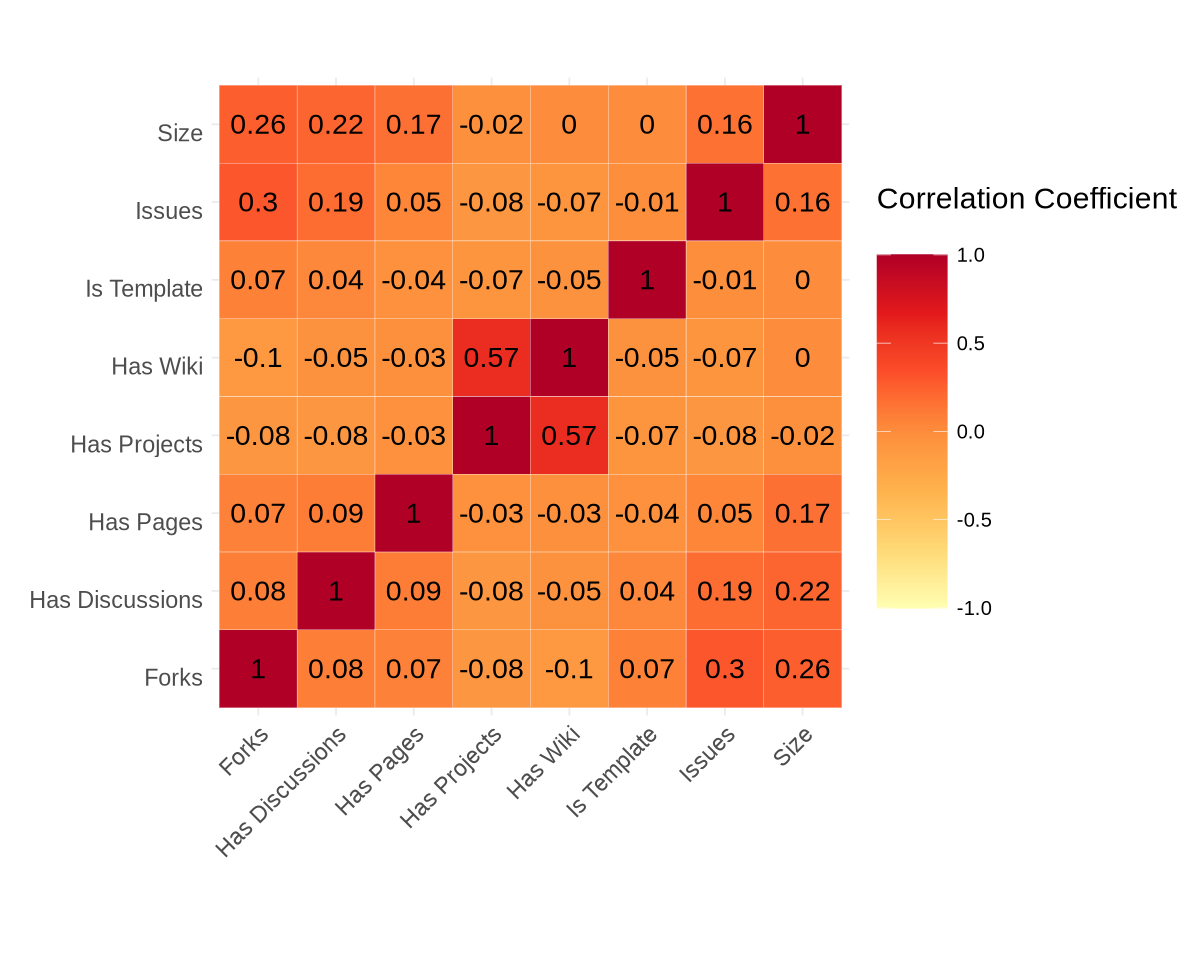

In [6]:
# Check for multicollinearity among covariates using correlation matrix on heatmap
options(repr.plot.width = 10, repr.plot.height = 8) 
repo_sample_log_bin <- 
    repo_sample_log %>%
    mutate(across(where(is.logical), as.numeric)) %>%
    mutate(`Has Discussions` = as.numeric(`Has Discussions`))
corr_matrix_repo <-
    repo_sample_log_bin %>%
    select(-Stars) %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")
plot_corr_matrix_repo <-
    corr_matrix_repo %>%
    ggplot(mapping = aes(var1, var2)) +
    geom_tile(mapping = aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() +
    geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)
plot_corr_matrix_repo

Note that the largest (in absolute value) correlation coefficient is between 'Has Wiki' and 'Has Projects', with a value of 0.57. This is noticeable but not large enough to be cause for concern or to consider dropping either variable.

In [7]:
# Split into training and testing set, reorder so that Stars is first column
repo_sample_log <- 
    repo_sample_log %>%
    mutate(id = row_number()) %>%
    select(Stars, everything())

training_repo <-
    repo_sample_log %>%
    slice_sample(prop = 0.7, replace = FALSE)

testing_repo <-
    repo_sample_log %>%
    anti_join(training_repo, by = "id") %>%
    select(-id)

training_repo <- 
    training_repo %>%
    select(-id)
head(training_repo)

Stars,Size,Forks,Issues,Has Projects,Has Wiki,Has Pages,Has Discussions,Is Template
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<fct>,<lgl>
5.765191,4.564348,3.850148,9,TRUE,TRUE,FALSE,FALSE,FALSE
7.003065,6.504288,6.070738,38,TRUE,TRUE,FALSE,FALSE,FALSE
6.068426,8.191740,3.713572,6,FALSE,FALSE,FALSE,FALSE,FALSE
5.913503,2.302585,4.624973,2,TRUE,TRUE,FALSE,FALSE,FALSE
7.460490,9.567455,6.366470,46,FALSE,TRUE,FALSE,TRUE,FALSE
8.002025,11.442138,5.817111,14,TRUE,TRUE,FALSE,TRUE,FALSE


In [8]:
# Full model (use as baseline for comparison)
repo_full <- lm(Stars ~., training_repo)
summary(repo_full)


Call:
lm(formula = Stars ~ ., data = training_repo)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.93807 -0.44867 -0.09402  0.41370  2.92126 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            3.7513016  0.1373610  27.310  < 2e-16 ***
Size                  -0.0145124  0.0110779  -1.310   0.1906    
Forks                  0.5700064  0.0231236  24.650  < 2e-16 ***
Issues                 0.0002589  0.0001549   1.671   0.0951 .  
`Has Projects`TRUE    -0.1070930  0.0929039  -1.153   0.2494    
`Has Wiki`TRUE         0.0216738  0.0786271   0.276   0.7829    
`Has Pages`TRUE        0.1130292  0.0683621   1.653   0.0987 .  
`Has Discussions`TRUE  0.4345588  0.0768969   5.651 2.33e-08 ***
`Is Template`TRUE      0.1115955  0.3060732   0.365   0.7155    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6771 on 691 degrees of freedom
Multiple R-squared:  0.5392,	Adjusted R-squared:  0.

In [9]:
# Obtain out-of-sample predictions for repos in testing set, using full model
repo_test_pred_full <- predict(repo_full, newdata = testing_repo)
head(repo_test_pred_full)

1        2        3        4        5        6 
6.461030 6.315739 7.089592 6.084883 6.060254 7.206068

In [10]:
# Compute Root Mean Squared Error to evaluate full predictive model
repo_RMSE_models <- tibble(
    Model = "Full Regression",
    RMSE = rmse(model = repo_full,
                data = testing_repo)
    )
repo_RMSE_models

Model,RMSE
<chr>,<dbl>
Full Regression,0.7048372


In [11]:
# Use forward-selection to select a reduced linear regression model
repo_forward_selection <- leaps::regsubsets(
    x = Stars ~., nvmax = 7,
    data = training_repo,
    method = "forward")

repo_forward_summary <- summary(repo_forward_selection)
repo_forward_summary <- tibble(
    n_input_variables = 1:7,
    RSS = repo_forward_summary$rss,
    BIC = repo_forward_summary$bic,
    Cp = repo_forward_summary$cp)
summary(repo_forward_selection)
repo_forward_summary

Subset selection object
Call: regsubsets.formula(x = Stars ~ ., nvmax = 7, data = training_repo, 
    method = "forward")
8 Variables  (and intercept)
                      Forced in Forced out
Size                      FALSE      FALSE
Forks                     FALSE      FALSE
Issues                    FALSE      FALSE
`Has Projects`TRUE        FALSE      FALSE
`Has Wiki`TRUE            FALSE      FALSE
`Has Pages`TRUE           FALSE      FALSE
`Has Discussions`TRUE     FALSE      FALSE
`Is Template`TRUE         FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         Size Forks Issues `Has Projects`TRUE `Has Wiki`TRUE `Has Pages`TRUE
1  ( 1 ) " "  "*"   " "    " "                " "            " "            
2  ( 1 ) " "  "*"   " "    " "                " "            " "            
3  ( 1 ) " "  "*"   "*"    " "                " "            " "            
4  ( 1 ) " "  "*"   "*"    " "                " "            "*"            
5  ( 1 ) "*"  "*"

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,338.2211,-483.4285,41.683322
2,320.7328,-514.0414,5.540170
3,319.5003,-510.1854,4.851965
4,318.4744,-505.8856,4.614435
5,317.6405,-501.1699,4.795585
6,316.9132,-496.2233,5.209458
7,316.8521,-489.8074,7.075985


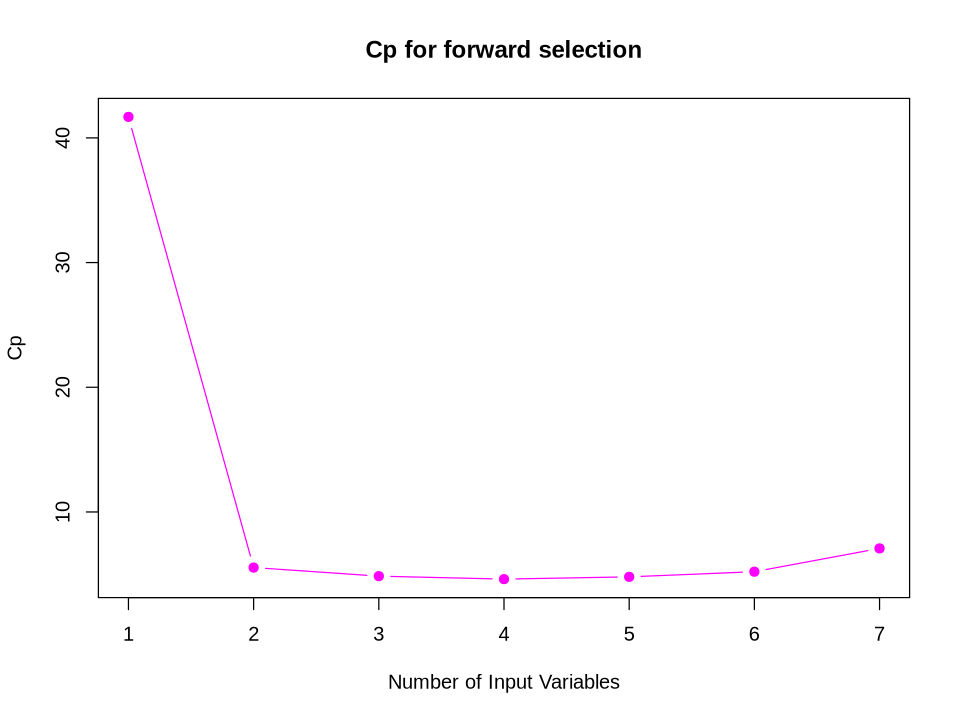

In [12]:
# Visualize Cp values of models
options(repr.plot.width = 8, repr.plot.height = 6) 
plot(summary(repo_forward_selection)$cp,
     main = "Cp for forward selection",
     xlab = "Number of Input Variables", 
     ylab = "Cp",
     type = "b",
     pch = 19,
     col = "magenta"
)

In [13]:
# We select the model with the lowest Cp value
repo_selection_summary <- summary(repo_forward_selection)
cp_min = which.min(repo_selection_summary$cp)
variables = repo_selection_summary$which[cp_min, ]
repo_reduced = lm(Stars ~ ., data = training_repo[variables])
summary(repo_reduced)


Call:
lm(formula = Stars ~ ., data = training_repo[variables])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96574 -0.46402 -0.09113  0.40584  2.84042 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           3.5913718  0.1025875  35.008  < 2e-16 ***
Forks                 0.5642639  0.0224059  25.184  < 2e-16 ***
Issues                0.0002494  0.0001539   1.621    0.105    
`Has Pages`TRUE       0.1009866  0.0674930   1.496    0.135    
`Has Discussions`TRUE 0.4227626  0.0748959   5.645 2.41e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6769 on 695 degrees of freedom
Multiple R-squared:  0.5367,	Adjusted R-squared:  0.5341 
F-statistic: 201.3 on 4 and 695 DF,  p-value: < 2.2e-16


**2.2 Table to report results**

In [14]:
# Compare RMSE of reduced model with that of full (baseline) model
repo_RMSE_models_compare <-
    rbind(
        model = repo_RMSE_models,
        data = tibble(Model = "Reduced Regression",
                      RMSE = rmse(model = repo_reduced,
                                  data = testing_repo))
        )
repo_RMSE_models_compare
# Print names of selected covariates
selected_var <- names(coef(repo_forward_selection, cp_min))[-1]
selected_var

,Model,RMSE
,<chr>,<dbl>
1,Full Regression,0.7048372
2,Reduced Regression,0.7002722


[1] "Forks"                 "Issues"                "`Has Pages`TRUE"      
[4] "`Has Discussions`TRUE"

**2.3 Interpretation of results**
<br> The table above shows that the Root Mean Squared Error of our reduced model, selected using forward selection and containing 4 covariates, is slightly lower than that of the full model containing all 7 covariates. This suggests that our reduced model has slightly higher prediction performance compared with the full model. To address our research question: the results suggest that we can use two continuous variables (Forks and Issues) and two categorical variables (Has Pages and Has Discusssions) to predict the number of Stars that a repository has.